In [133]:
# importing needed packages
import pandas as pd
import os
from time import perf_counter # out of general interest
import numpy as np
pd.set_option('display.max_columns', None)


In [134]:
# declaring data paths
data_path = ["drive", "Othercomputers", "Mein_Laptop", "hw01_lighter_updated"]

### [RQ8]
Charts, statistical tests, and analysis methods are splendid tools to illustrate your data-driven decisions to check whether a hypothesis is correct.

1. Can you demonstrate that readers usually rate the longest books as the worst?
2. Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?
3. About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.
4. It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.
5. Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

#### ad 1.
Can you demonstrate that readers usually rate the longest books as the worst?


<ipython-input-137-204d46260b95>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['log(num_pages)'] = np.log10(chunk['num_pages'])


2000
4000


<ipython-input-137-204d46260b95>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chunk['log(num_pages)'] = np.log10(chunk['num_pages'])


<Axes: xlabel='log(num_pages)', ylabel='average_rating'>

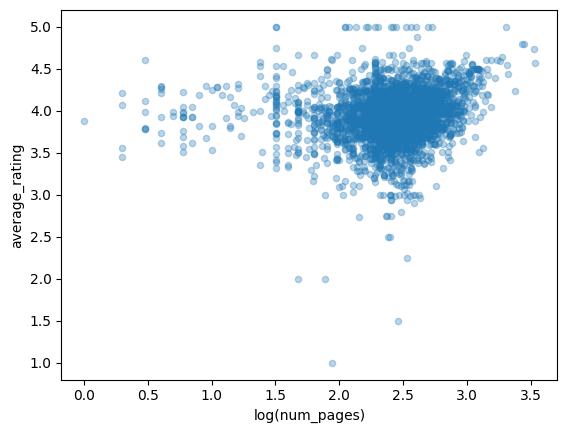

In [137]:

books_df = None
processed_rows = 0
chunksize = 2*10**3
nrows = 4*10**3
flag = True

chunks = pd.read_json(os.path.join(*data_path, 'lighter_books' + '.json'), lines=True, chunksize=chunksize, nrows=nrows, dtype={'num_pages':'numeric', 'average_rating':'numeric'})
for chunk in chunks:
    processed_rows += len(chunk)
    chunk = chunk[['ratings_count','average_rating','num_pages']]
    chunk['ratings_count'] = pd.to_numeric(chunk['ratings_count'], errors='coerce')
    chunk['average_rating'] = pd.to_numeric(chunk['average_rating'], errors='coerce')
    chunk['num_pages'] = pd.to_numeric(chunk['num_pages'], errors='coerce')
    chunk = chunk[ (~chunk['average_rating'].isna()) & (~chunk['num_pages'].isna()) & (~chunk['ratings_count'].isna())
                    & (chunk['num_pages']>0) & (0 <= chunk['average_rating']) & (chunk['average_rating'] <= 5) & (chunk['ratings_count']>0 )]
    # chunk['average_rating'] = chunk['average_rating']
    chunk['log(num_pages)'] = np.log10(chunk['num_pages'])
    if flag:
        books_df = chunk
        flag = False
    else:
        books_df = pd.concat([books_df, chunk], axis=0)
    print(processed_rows)
# books_df
books_df.plot.scatter(y='average_rating', x='log(num_pages)', alpha = 0.3)

The scatterplot shows rather the opposite. Starting from 10^2.5 pages the average ratings are increasing with increasing number of pages and concentrating around 4.5.

#### ad 2.
Compare the average rate distribution for English and non-English books with a proper statistical procedure. What can you conclude about those two groups?

After removing the books where no language is given we group the books by english or non-english. When done this we perform a Kolmogorov-Smirnov-Test to compare the distribution of their average-rate (:=average-ratings).

We have found the following languages:

In [ ]:
processed_rows = 0
chunksize = 2*10**5
nrows = None
languages_set = set()
chunks = pd.read_json(os.path.join(*data_path, 'lighter_books' + '.json'), lines=True, chunksize=chunksize, nrows=nrows, dtype={'num_pages':'numeric', 'average_rating':'numeric'})
for chunk in chunks:
    processed_rows += len(chunk)
    languages_set = languages_set.union(set(chunk['language']))
    print(processed_rows)
languages_set

199963
399919
599873


We divided them into english, non-english and no-languages. The first and the latter we defined explicitly the one in the middle is defined to be the rest.

In [ ]:
english_languages = {'en',
 'en-CA',
 'en-GB',
 'en-IN',
 'en-US',
 'eng',
 'enm'}
no_languages = {'',
 '--',
 'Select...',}

In [ ]:
books_df = None
processed_rows = 0
chunksize = 2*10**3
nrows = 4*10**3
flag = True
chunks = pd.read_json(os.path.join(*data_path, 'lighter_books' + '.json'), lines=True, chunksize=chunksize, nrows=nrows, dtype={'num_pages':'numeric', 'average_rating':'numeric'})
for chunk in chunks:
    processed_rows += len(chunk)
    chunk = chunk[['ratings_count','average_rating','language']]
    chunk = chunk[ ~(chunk['language'].isin(no_languages)) ]
    chunk['ratings_count'] = pd.to_numeric(chunk['ratings_count'], errors='coerce')
    chunk['average_rating'] = pd.to_numeric(chunk['average_rating'], errors='coerce')
    chunk = chunk[ (~chunk['average_rating'].isna()) & (~chunk['ratings_count'].isna())
                    & (0 <= chunk['average_rating']) & (chunk['average_rating'] <= 5) & (chunk['ratings_count']>0 )]
    chunk['en'] = chunk['language'].apply(lambda entry : entry[:2] == "en" )
    if flag:
        books_df = chunk
        flag = False
    else:
        books_df = pd.concat([books_df, chunk], axis=0)
    print(processed_rows)

grouped_series = books_df.groupby('en')['average_rating'].apply(list)
grouped_df = pd.DataFrame(grouped_series)
grouped_df

In [ ]:
def eval_pval(pval, alpha, alternative):
    """
    Takes a p-value, a significance level alpha and the alternative formulated as an appropriate string
    Returns true iff there's significance for the alternative. Otherwise it returns false.
    Further prints a sentence describing the result to the console.
    """
    print('assuming a test-level of alpha =', alpha)
    strres = ""
    if pval <= alpha:
        strres = ", i.e. less than or equal to alpha, \nthere's significance for " + alternative + "."
    else:
        strres = ", i.e. strictly greater than alpha, \nthere's no significance for " + alternative + "."

    print("Since the pvalue is approximately", '{:.6f}'.format(pval), strres)
    return pval <= alpha


# now performing the kolmogorov-smirnov-test to check equality of the two distributions:
from scipy.stats import ks_2samp # kolmogorov-smirnov-two-sample-test
alpha = 0.05
_, pval  = ks_2samp(grouped_df.loc[False,'average_rating'], grouped_df.loc[True,'average_rating'])
alpha = 0.05
eval_pval(pval, alpha, "a difference in the analyzed distributions")

end = perf_counter()
duration = end - start
print('The process lasted approximately', '{:.2f}'.format(duration), "seconds lasted the process.")




#### ad 3.
About the two groups in the previous question, extract helpful statistics like mode, mean, median, and quartiles, explaining their role in a box plot.

Next we provide some (helpful) statistics and a boxplot. First we want to describe a boxplot as it is created by the method we use:

"The box extends from the first quartile (Q1) to the third quartile (Q3) of the data, with a line at the median. The whiskers extend from the box to the farthest data point lying within 1.5x the inter-quartile range (IQR) from the box. Flier points are those past the end of the whiskers."

source: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html

In [ ]:
from matplotlib import pyplot as plt
plt.title("Boxplot of average ratings")
plt.boxplot([grouped_df.loc[True,'average_rating'], grouped_df.loc[False,'average_rating']], labels =["english books","non-english books"])
plt.show()
# description =
books_df.describe()
# description['mode'] = books_df.mode()
# description
# books_df.mode()

Next we see the **mode** of ratings_count, average_rating, language and en."
The mode is probably only useful for "langauge" and "en" since these are non-metric, even categorical.


In [ ]:
books_df.mode()


#### ad 4.
It seems reasonable to assume that authors with more fans should have more reviews, but maybe their fans are a bit lazy. Confirm or reject this with a convenient statistical test or a predictive model.

In [ ]:
books_df = None # to hopefully free some memory
authors_df = None
processed_rows = 0
chunksize = 2*10**3
nrows = 4*10**3
flag = True
chunks = pd.read_json(os.path.join(*data_path, 'lighter_authors' + '.json'), lines=True, chunksize=chunksize, nrows=nrows, dtype={'num_pages':'numeric', 'average_rating':'numeric'})
for chunk in chunks:
    processed_rows += len(chunk)
    chunk = chunk[['text_reviews_count', 'fans_count']]
    chunk['text_reviews_count'] = pd.to_numeric(chunk['text_reviews_count'], errors='coerce')
    chunk['fans_count'] = pd.to_numeric(chunk['fans_count'], errors='coerce')
    chunk = chunk[ (~chunk['text_reviews_count'].isna()) & (~chunk['fans_count'].isna())
                    & (chunk['text_reviews_count']>=0 ) & (chunk['fans_count']>=0 )]
    chunk['8th-root(text_reviews_count)'] = (chunk['text_reviews_count'])**(1/8) # since we allow for 0-values, we use the root to lower the impact of outliers
    chunk['8th-root(fans_count)'] = (chunk['fans_count'])**(1/8)

    if flag:
        authors_df = chunk
        flag = False
    else:
        authors_df = pd.concat([books_df, chunk], axis=0)
    print(processed_rows)


authors_df.plot.scatter(x='fans_count', y='text_reviews_count', alpha = 0.1)
authors_df.plot.scatter(x='8th-root(fans_count)', y='8th-root(text_reviews_count)', alpha = 0.1)
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

model_set = authors_df[['fans_count','text_reviews_count']]
# model_set = model_set[ ~model_set['fans_count'].isna()]
# model_set = model_set[ ~model_set['text_reviews_count'].isna()]
# model_set = model_set[np.isfinite(model_set).all(1)]

model = LinearRegression()
model.fit(model_set[['fans_count']], model_set['text_reviews_count'])
score = model.score(model_set[['fans_count']], model_set['text_reviews_count'])





In [ ]:
print('We consider the rooted dataset:')
print('slope is', model.coef_[0])
print('intercept is' ,model.intercept_)
# print('residuals is', model.resid )
print('R-squared-Coefficient is', score)

In [ ]:
eps = 0.05
if model.coef_[0] > eps:
  print("Since the slope is significantly greater than zero \nwe see that the more fans an author has the more text_reviews he has. \nHence we can refuse the stated claim that fans of authors with more fans would be lazier. ")
elif model.coef_[0] < - eps:
  print("Since the slope is significantly lower than zero \nwe see that the more fans an author has the less text_reviews he has.  \nHence we can confirm the claim that fans of authors with more fans are lazier")
else:
  print("Since the slope does not differ significantly from zero \nwe there's no evidence for a correlation between fans_count and text_reviews_count.")


In [ ]:
print('The R-squared-Coefficient is with approximately', '{:.2f}'.format(score))
if score <= 0.1 :
  print("very low. Hence the model explains (nearly) nothing of the seen variance.")
elif score <= 0.5:
  print("is low. Hence the model does explain only little of the seen variance.")
elif score <= 0.7:
  print("is at least half. Hence the model does explain some of the seen variance.")
elif score <= 0.9:
  print("is high. Hence the model does explain a big part of the seen variance.")
else:
  print("is very high. Hence the model does explain (nearly) all of the seen variance.")



#### ad 5.
Provide a short survey about helpful statistical tests in data analysis and mining: focus on hypothesis design and the difference between parametric and nonparametric tests, explaining the reasons behind the choice of one of these two tests.

##### Hypothesis testing:
The alternative is (if possible) the claim we want to confirm. However sometimes it is not possible to choose what we want to claim as the alternative. For example if we are testing "theta $=$ 0" vs. "theta $\neq$ 0" often it is only possible to choose "theta==0" as the hypothesis.

Whenever we test hypotheses we need to determine a significance level, often called alpha, which determines the highest acceptable error of 1st kind, to determine if there's evidence for the alternative or not.

###### (non-)parametric tests:
Parametric tests assume that the distribution of data is known up to a paramter $\theta \in \mathbb{R}^d$ for some $d \in \mathbb{N}$. Given that we know the distribution (with high probability) we should use these since they are more appropriate for our data.

However if we don't know the distribution we should go for nonparametric tests, since these do not make assumptions on the distribution of the data. With less requirements for a tests one naturally gets less out of it, but few is better than nothing or something wrong.

###### Some useful tests are...
- fisher and chi-square for independence of binary resp. categorical variables
- kolmogorov-smirnov or mann-whitney-u to compare two unknown distributions
- regression tests
  - (multiple) linear regression
  - logistic regression
  - polynomial regression
